# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")
seed = 0

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

scaler = StandardScaler()
X = scaler.fit_transform(X)

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [3]:
(X_train.shape, X_test.shape)

((1483, 10), (371, 10))

In [4]:
dataset

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001



Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

1. ¿De qué se trata el conjunto de datos?

El *dataset* contiene un conjunto de datos que describen el comportamiento crediticio histórico de los clientes de un banco que hayan solicitado presetamos recientes.

2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?

La variable objetivo `TARGET` se trata de una variable binaria que puede asumir el valor 1, si el cliente no pagó el credito solicitado, y 0 caso contrario.


3. ¿Qué información (atributos) hay disponible para hacer la predicción?

- LOAN    Monto de préstamo requerido.
- MORTDUE Saldo de crédito hipotecario existente.
- VALUE   Valor actual de la propiedad.
- YOJ     Años en el trabajo actual.
- DEROG   Número de informes despectivos.
- DELINQ  Número de créditos en estado moroso.
- CLAGE   Linea de crédito más antigua en meses.
- NINQ    Número reciente de lineas de crédito.
- CLNO    Número de lineas de crédito.
- DEBTINC Cociente de deuda e ingresos.

4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

. LOAN
. DELINQ
. DEBTINC
. DEROG

## Análisis de la variable `TARGET`

In [5]:
dataset["TARGET"].value_counts()
nof_targets_train = len(y_train)
nof_ones_train = np.sum(y_train == 1)
nof_zeros_train = np.sum(y_train == 0)

nof_targets_test = len(y_test)
nof_ones_test = np.sum(y_test == 1)
nof_zeros_test = np.sum(y_test == 0)

(nof_ones_train / nof_targets_train, nof_ones_test / nof_targets_test)

(0.16925151719487525, 0.15633423180592992)

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [6]:
clf = SGDClassifier(random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [7]:
y_pred

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       313
           1       0.57      0.40      0.47        58

    accuracy                           0.86       371
   macro avg       0.73      0.67      0.69       371
weighted avg       0.84      0.86      0.85       371



- 0 (N): Pagó el prestamo.
- 1 (P): No pagó el prestamo.
- TP: Casos predichos que no pagarón y no pagaron efectivamente.
- TF: Casos predichos que pagaron y pagaron efectivamente.
- FP: Casos predichos que P (No pagó el prestamo) y pasó N (Pagó el prestamo).
- FN: Casos predichos que N (Pagó el prestamo) y pasó P (No pagó el prestamo).

- Recall: TP / (TP + FN)
- Precisión: TP / (TP + FP)
- F1-score : 2*(Precision*Recall/Precision + Recall)

Preferimos no tener FN a costa de algunos FP.

In [9]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(296, 17, 35, 23)

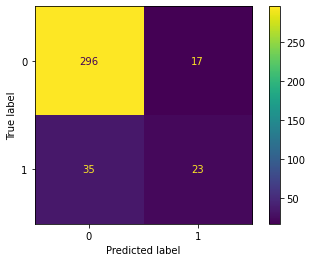

In [10]:
plot_confusion_matrix(clf, X_test, y_test)

In [11]:
clf.coef_.shape

(1, 10)

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [12]:
from sklearn.model_selection import GridSearchCV

# TODO: Check other params
param_grid = {
    'loss': ['hinge','log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l2','l1'],
    'eta0': [1e-3, 1e-4, 1e-5],
    'learning_rate': ['optimal', 'constant', 'adaptive']
    #'max_iter': [1000, 2000, 5000]
    
}

model = SGDClassifier(random_state=seed)
cv = GridSearchCV(model, param_grid, scoring=["recall", "accuracy", "precision", "f1"], cv=5, refit=False)
cv.fit(X_train, y_train)
#cv.fit(X, y)

results = cv.cv_results_
params = results['params']

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWa

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\metrics\_classification.py:

In [13]:
X.shape, y.shape

((1854, 10), (1854,))

In [14]:
results_df = pd.DataFrame(results)
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_eta0', 'param_learning_rate', 'param_loss',
       'param_penalty', 'params', 'split0_test_recall', 'split1_test_recall',
       'split2_test_recall', 'split3_test_recall', 'split4_test_recall',
       'mean_test_recall', 'std_test_recall', 'rank_test_recall',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision', 'split0_test_f1',
       'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1',
       'mean_test_f1', 'std_test_f1', 'rank_test_f1'],
      dtype='object')

In [15]:
relevant_metrics=["mean_test_recall", "std_test_recall",
            "mean_test_accuracy", "std_test_accuracy",
            "mean_test_precision", "std_test_precision", 'mean_test_f1',
            "rank_test_recall", 'rank_test_precision', 'rank_test_accuracy', 'rank_test_f1']

params= ["param_alpha", "param_loss", "param_penalty", 'param_eta0']

results_df= results_df[relevant_metrics + params]
results_df

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_alpha,param_loss,param_penalty,param_eta0
0,0.414431,0.074592,0.833479,0.025451,0.568875,0.187708,0.456685,66,313,322,35,0.00001,hinge,l2,0.001
1,0.497882,0.111752,0.828692,0.023464,0.510390,0.063662,0.491526,11,344,354,4,0.00001,hinge,l1,0.001
2,0.441569,0.105980,0.799711,0.036127,0.418914,0.083252,0.425818,47,402,409,95,0.00001,log,l2,0.001
3,0.321882,0.132541,0.838177,0.010913,0.586930,0.150451,0.385782,138,310,305,213,0.00001,log,l1,0.001
4,0.362824,0.078359,0.826736,0.026032,0.486050,0.094490,0.414515,92,357,359,129,0.00001,modified_huber,l2,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.171373,0.016512,0.857048,0.003987,0.915152,0.043140,0.288399,398,15,258,390,0.1,modified_huber,l1,0.00001
446,0.239216,0.044556,0.861769,0.006349,0.817509,0.058522,0.367194,331,128,149,306,0.1,squared_hinge,l2,0.00001
447,0.171373,0.016512,0.857048,0.003987,0.915152,0.043140,0.288399,398,15,258,390,0.1,squared_hinge,l1,0.00001
448,0.426431,0.127882,0.800439,0.043680,0.430541,0.106274,0.417718,59,394,404,119,0.1,perceptron,l2,0.00001


In [16]:
highest_rank= 1
results_df[results_df['rank_test_recall']== highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_alpha,param_loss,param_penalty,param_eta0
209,0.592863,0.106317,0.74045,0.049412,0.354787,0.035487,0.436528,1,421,443,66,0.001,perceptron,l1,0.001


In [17]:
results_df[results_df['rank_test_precision']== highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_alpha,param_loss,param_penalty,param_eta0
431,0.099686,0.018247,0.847609,0.003812,1.0,0.0,0.180798,430,1,301,425,0.1,hinge,l1,0.00001
441,0.099686,0.018247,0.847609,0.003812,1.0,0.0,0.180798,430,1,301,425,0.1,hinge,l1,0.00001


In [18]:
results_df[results_df['rank_test_f1']== highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_alpha,param_loss,param_penalty,param_eta0
189,0.41498,0.080413,0.860431,0.017319,0.662113,0.112648,0.497972,63,294,192,1,0.001,perceptron,l1,0.001
219,0.41498,0.080413,0.860431,0.017319,0.662113,0.112648,0.497972,63,294,192,1,0.001,perceptron,l1,0.0001
249,0.41498,0.080413,0.860431,0.017319,0.662113,0.112648,0.497972,63,294,192,1,0.001,perceptron,l1,0.00001


In [21]:
results_df.loc[results_df['rank_test_recall']== highest_rank, params]

,param_alpha,param_loss,param_penalty,param_eta0
209,0.001,perceptron,l1,0.001


In [22]:
clf = SGDClassifier(random_state=seed, alpha=0.001, loss= "perceptron", eta0= 0.001, penalty="l1")
clf.fit(X_train, y_train)
y_pred_best = clf.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       313
           1       0.50      0.21      0.29        58

    accuracy                           0.84       371
   macro avg       0.68      0.58      0.60       371
weighted avg       0.81      0.84      0.82       371



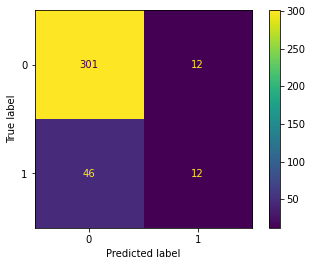

In [24]:
plot_confusion_matrix(clf, X_test, y_test)

In [19]:
results_df.max()

mean_test_recall            0.592863
std_test_recall             0.489898
mean_test_accuracy          0.869199
std_test_accuracy           0.324215
mean_test_precision              1.0
std_test_precision               0.4
mean_test_f1                0.497972
rank_test_recall                 436
rank_test_precision              436
rank_test_accuracy               450
rank_test_f1                     436
param_alpha                      0.1
param_loss             squared_hinge
param_penalty                     l2
param_eta0                     0.001
dtype: object

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [32]:
# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [33]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [34]:
(X_train.shape, X_test.shape)

((1483, 10), (371, 10))

In [35]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Train accuracy: {train_acc:0.2}')
print(f'Test accuracy: {test_acc:0.2}')

Train accuracy: 1.0
Test accuracy: 0.88


In [37]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371



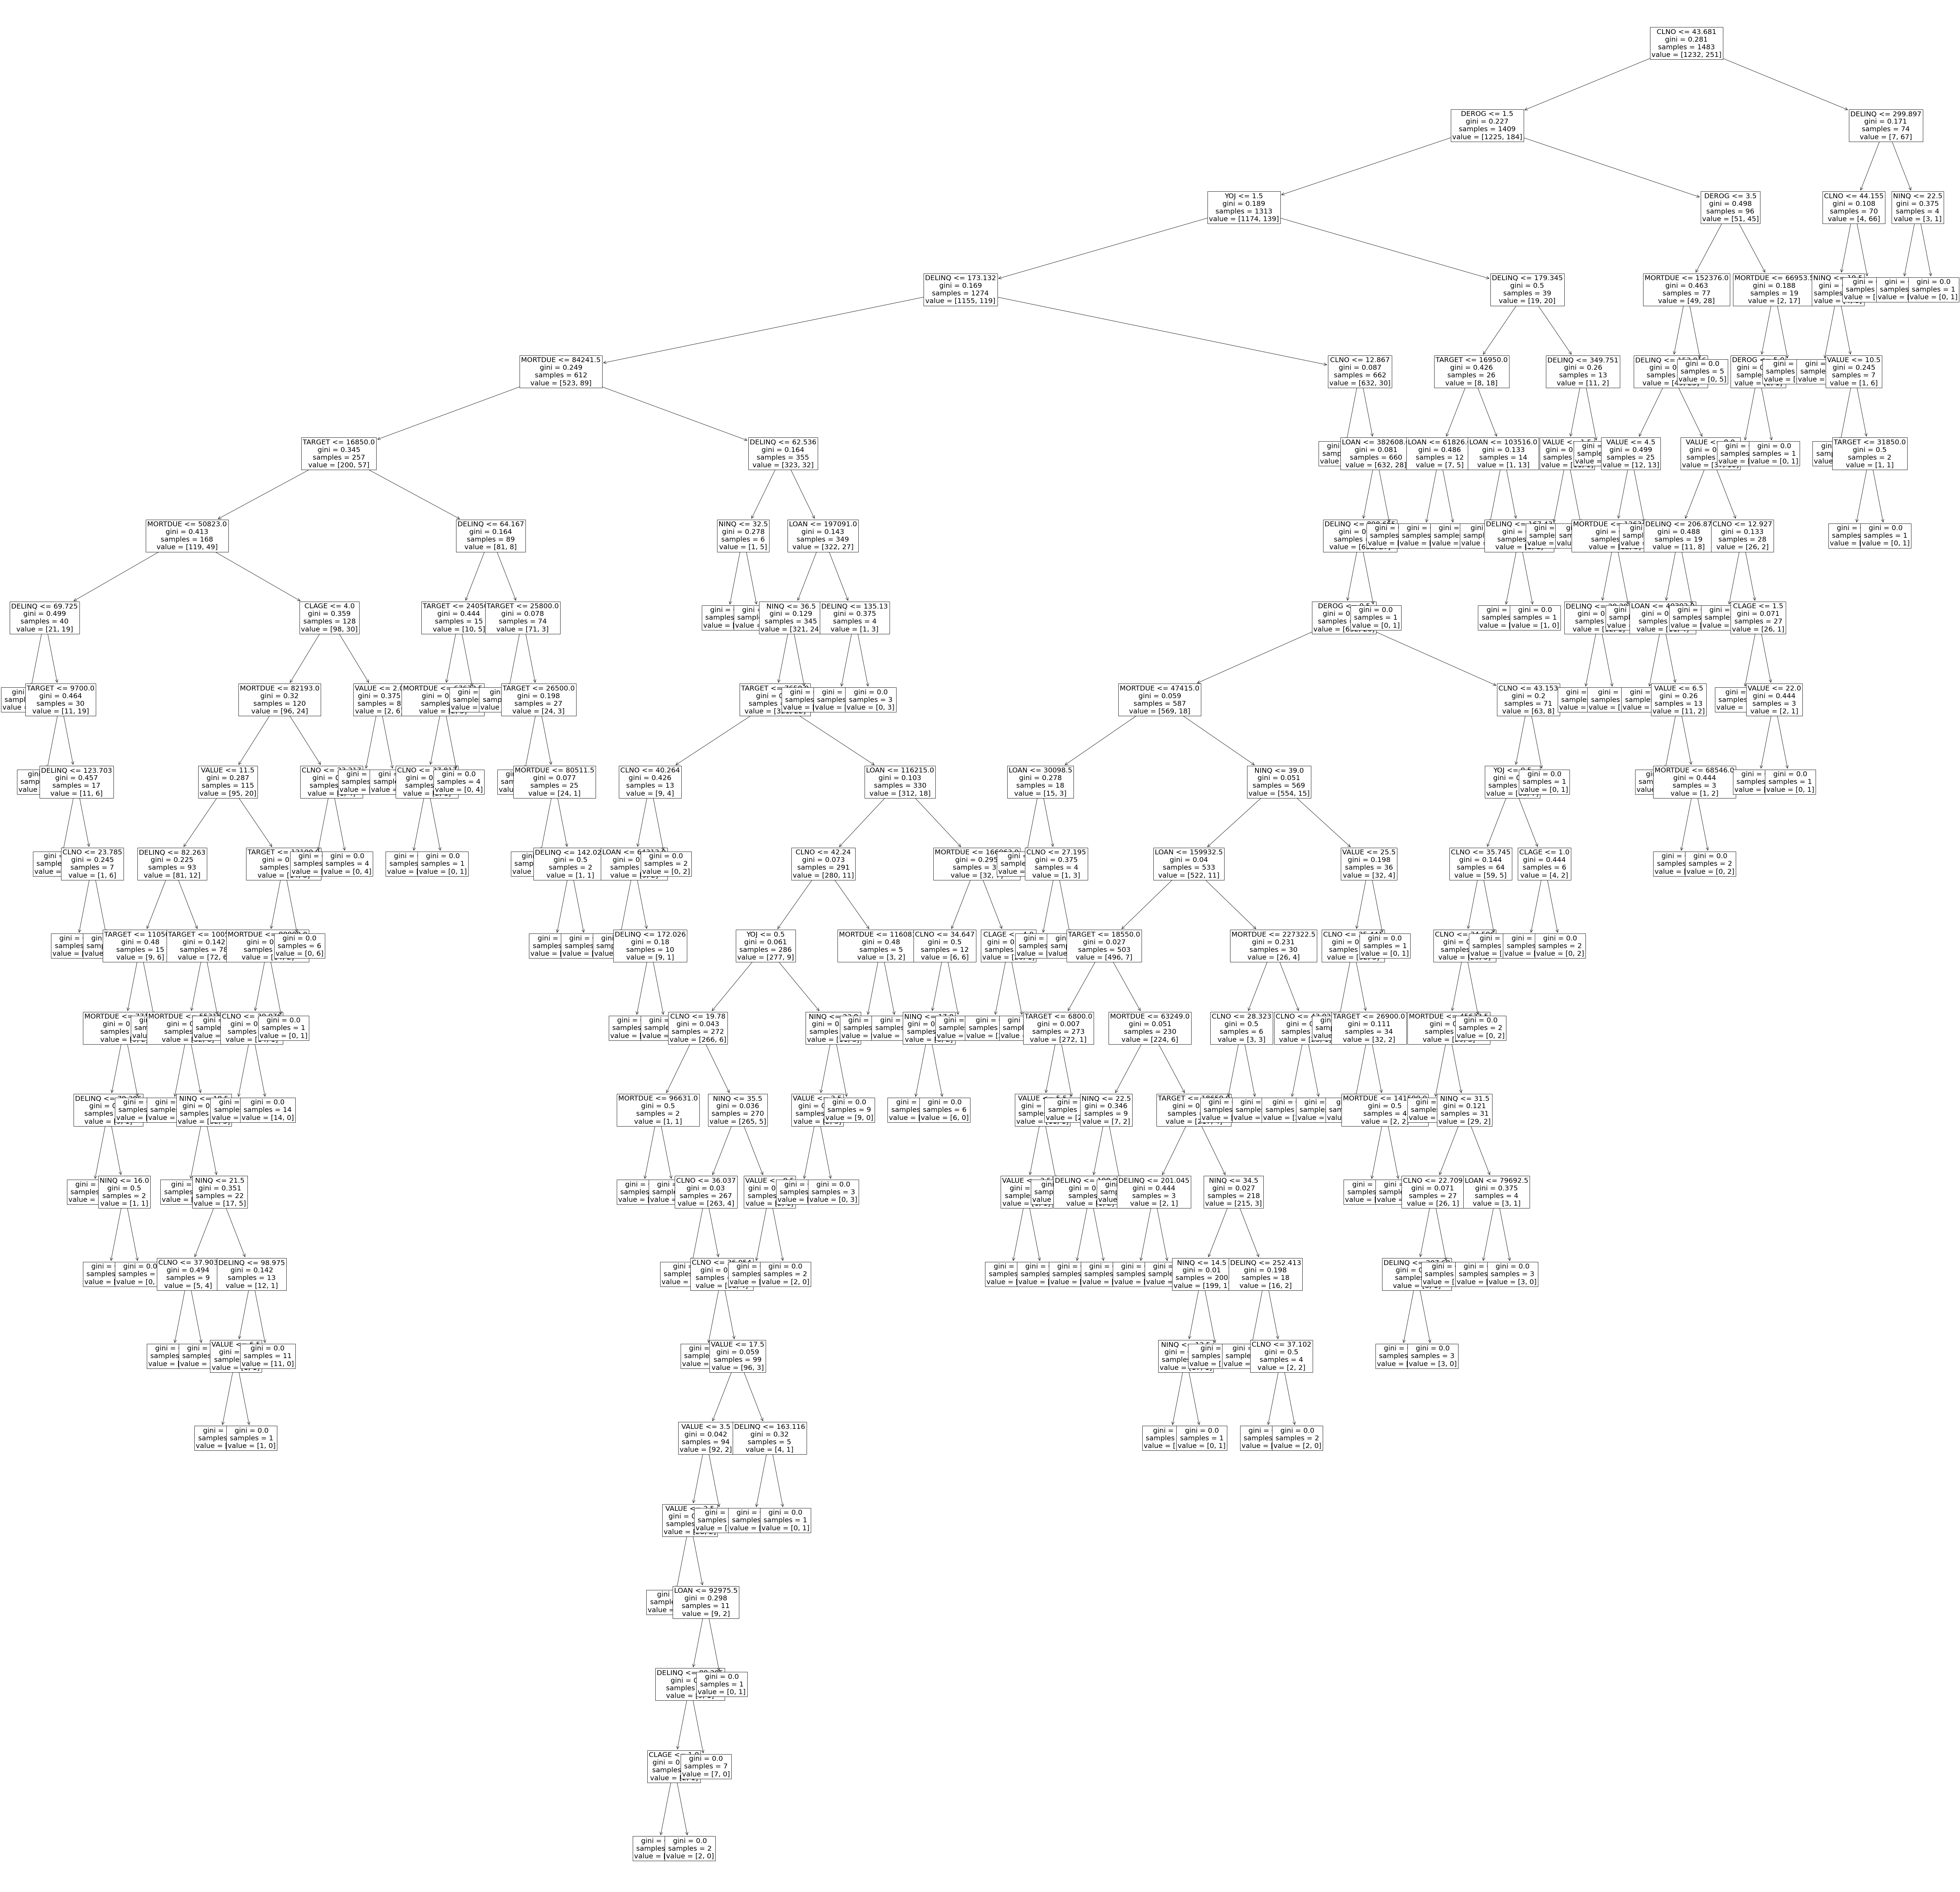

In [43]:
from sklearn.tree import plot_tree

plt.figure(figsize=(100,100))
plot_tree(clf, fontsize=20, feature_names= dataset.columns);
#plt.show()
plt.savefig("arbol.jpg")

In [58]:
from sklearn.model_selection import GridSearchCV

# TODO: Check other params
param_grid = {
    'max_depth': [6,7, 8, 9, 10],
    'criterion':['gini', 'entropy'],
    'min_samples_split': [100, 200, 300, 400, 500, 600, 700],
    'min_samples_leaf':[5, 10, 20, 30, 40, 50]

    
}

model_tree = DecisionTreeClassifier(random_state=seed)
cv = GridSearchCV(model_tree, param_grid, scoring=["recall", "accuracy", "precision", "f1"], cv=5, refit=False)
cv.fit(X_train, y_train)
#cv.fit(X, y)

results_tree = cv.cv_results_
params_tree = results_tree['params']

In [59]:
results_df_tree = pd.DataFrame(results_tree)
results_df_tree.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_min_samples_leaf',
       'param_min_samples_split', 'params', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'split3_test_recall',
       'split4_test_recall', 'mean_test_recall', 'std_test_recall',
       'rank_test_recall', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
       'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy',
       'split0_test_precision', 'split1_test_precision',
       'split2_test_precision', 'split3_test_precision',
       'split4_test_precision', 'mean_test_precision', 'std_test_precision',
       'rank_test_precision', 'split0_test_f1', 'split1_test_f1',
       'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1',
       'std_test_f1', 'rank_test_f1'],
      dtype='object')

In [60]:
relevant_metrics=["mean_test_recall", "std_test_recall",
            "mean_test_accuracy", "std_test_accuracy",
            "mean_test_precision", "std_test_precision", 'mean_test_f1',
            "rank_test_recall", 'rank_test_precision', 'rank_test_accuracy', 'rank_test_f1']

params_tree= ['param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split']

results_df_tree= results_df_tree[relevant_metrics + params_tree]
results_df_tree

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split
0,0.358431,0.040551,0.870541,0.009560,0.756601,0.100281,0.482977,64,366,140,69,gini,6,5,100
1,0.358431,0.040551,0.870541,0.009560,0.756601,0.100281,0.482977,64,366,140,69,gini,6,5,200
2,0.358431,0.040551,0.871888,0.009197,0.766818,0.095425,0.485541,64,352,25,53,gini,6,5,300
3,0.358431,0.040551,0.871888,0.009197,0.766818,0.095425,0.485541,64,352,25,53,gini,6,5,400
4,0.358431,0.040551,0.871888,0.009197,0.766818,0.095425,0.485541,64,352,25,53,gini,6,5,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.266824,0.063453,0.870546,0.011663,0.892844,0.075520,0.407529,291,61,75,291,entropy,10,50,300
416,0.266824,0.063453,0.870546,0.011663,0.892844,0.075520,0.407529,291,61,75,291,entropy,10,50,400
417,0.266824,0.063453,0.870546,0.011663,0.892844,0.075520,0.407529,291,61,75,291,entropy,10,50,500
418,0.266824,0.063453,0.870546,0.011663,0.892844,0.075520,0.407529,291,61,75,291,entropy,10,50,600


In [61]:
highest_rank= 1
results_df_tree[results_df_tree['rank_test_recall']== highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split
49,0.37851,0.063316,0.867172,0.016772,0.703303,0.094410,0.489678,1,417,393,49,gini,7,10,100
50,0.37851,0.063316,0.871212,0.009315,0.730290,0.042238,0.495920,1,382,51,21,gini,7,10,200
51,0.37851,0.063316,0.871212,0.009315,0.730290,0.042238,0.495920,1,382,51,21,gini,7,10,300
52,0.37851,0.063316,0.871212,0.009315,0.730290,0.042238,0.495920,1,382,51,21,gini,7,10,400
53,0.37851,0.063316,0.871212,0.009315,0.730290,0.042238,0.495920,1,382,51,21,gini,7,10,500
54,0.37851,0.063316,0.871212,0.009315,0.730290,0.042238,0.495920,1,382,51,21,gini,7,10,600
55,0.37851,0.063316,0.871212,0.009315,0.730290,0.042238,0.495920,1,382,51,21,gini,7,10,700
91,0.37851,0.063316,0.867172,0.016772,0.703303,0.094410,0.489678,1,417,393,49,gini,8,10,100
92,0.37851,0.063316,0.871212,0.009315,0.730290,0.042238,0.495920,1,382,51,21,gini,8,10,200
93,0.37851,0.063316,0.871212,0.009315,0.730290,0.042238,0.495920,1,382,51,21,gini,8,10,300


In [62]:
results_df_tree[results_df_tree['rank_test_precision']== highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split
29,0.254824,0.043428,0.869194,0.009254,0.902844,0.085125,0.395927,361,1,191,356,gini,6,40,200
30,0.254824,0.043428,0.869194,0.009254,0.902844,0.085125,0.395927,361,1,191,356,gini,6,40,300
31,0.254824,0.043428,0.869194,0.009254,0.902844,0.085125,0.395927,361,1,191,356,gini,6,40,400
32,0.254824,0.043428,0.869194,0.009254,0.902844,0.085125,0.395927,361,1,191,356,gini,6,40,500
33,0.254824,0.043428,0.869194,0.009254,0.902844,0.085125,0.395927,361,1,191,356,gini,6,40,600
34,0.254824,0.043428,0.869194,0.009254,0.902844,0.085125,0.395927,361,1,191,356,gini,6,40,700
71,0.254824,0.043428,0.869194,0.009254,0.902844,0.085125,0.395927,361,1,191,356,gini,7,40,200
72,0.254824,0.043428,0.869194,0.009254,0.902844,0.085125,0.395927,361,1,191,356,gini,7,40,300
73,0.254824,0.043428,0.869194,0.009254,0.902844,0.085125,0.395927,361,1,191,356,gini,7,40,400
74,0.254824,0.043428,0.869194,0.009254,0.902844,0.085125,0.395927,361,1,191,356,gini,7,40,500


In [57]:
results_df_tree[results_df_tree['rank_test_f1']== highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split
462,0.278824,0.058979,0.867852,0.014537,0.845353,0.138419,0.4144,113,108,108,1,entropy,6,50,100
504,0.278824,0.058979,0.867852,0.014537,0.845353,0.138419,0.4144,113,108,108,1,entropy,7,50,100
546,0.278824,0.058979,0.867852,0.014537,0.845353,0.138419,0.4144,113,108,108,1,entropy,8,50,100
588,0.278824,0.058979,0.867852,0.014537,0.845353,0.138419,0.4144,113,108,108,1,entropy,9,50,100
630,0.278824,0.058979,0.867852,0.014537,0.845353,0.138419,0.4144,113,108,108,1,entropy,10,50,100


In [21]:
results_df_tree.loc[results_df_tree['rank_test_recall']== highest_rank, params]

,param_alpha,param_loss,param_penalty,param_eta0
209,0.001,perceptron,l1,0.001


### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html